In [401]:
# !pip install seaborn
# !pip install scipy

In [402]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import dill
import copy
import numpy as np
from matplotlib.ticker import MaxNLocator

from scipy.stats import sem
from scipy.stats import sem
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["axes.xmargin"] = 0
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"

In [403]:
def get_sweeps(project):
    sweeps = []
    for sweep in project:
        sweeps.append((sweep.name, sweep.id))
    return sweeps[::-1]


def get_run_links(sweeps, project_name):
    runs = []
    for sweep_name, sweep_link in sweeps:
        sweep = wandb.Api().sweep(f"lucacorbucci/{project_name}/{sweep_link}")
        run_list_sweep = []
        for run in sweep.runs:
            run_list_sweep.append(run.id)
        runs.append((sweep_name, run_list_sweep[::-1]))
    return runs


def get_run_data(run_links_per_sweep, project_name):
    run_data = []
    for sweep_name, sweep in run_links_per_sweep:
        print("Downloading data for a sweep")
        tmp_run_data = []
        for run_link in sweep:
            run = wandb.Api().run(f"lucacorbucci/{project_name}/{run_link}")

            tmp_run_data.append(pd.DataFrame(run.scan_history()))
        run_data.append((sweep_name, tmp_run_data))
    return run_data


def remove_nan(column_names, dataframe):
    column_names = [
        column_name for column_name in column_names if column_name in dataframe.columns
    ]

    current_df = dataframe[column_names]
    # consider each column in training_data_disparity independently and
    # remove the rows where we have NaN
    new_columns = []

    for column in current_df.columns:
        new_values = list(current_df[column].dropna())
        new_columns.append(new_values)

    # if the lists have different lengths, we need to modify them so that
    # we have the same length:
    try:
        min_size = min([len(item) for item in new_columns])
        new_columns = [item[:min_size] for item in new_columns]

        # create the new dataframe with baseline_test_nodes_columns_disparity_dataset as columns
        # names and new_columns as values
        new_df = pd.DataFrame(dict(zip(column_names, new_columns)))
        return new_df
    except:
        return None


def download_runs(project_name):
    if not os.path.exists(f"./plots_data/data_{project_name}.pkl"):
        project_details = wandb.Api().runs(f"lucacorbucci/{project_name}")
        project_data = {}
        for run in project_details:
            print("Downloading run ", run.id)
            run_df = pd.DataFrame(
                wandb.Api().run(f"lucacorbucci/{project_name}/{run.id}").scan_history()
            )
            if run.name not in project_data:
                project_data[run.name] = []
            project_data[run.name].append(run_df)
        with open(f"./plots_data/data_{project_name}.pkl", "wb") as f:
            dill.dump(project_data, f)
    else:
        with open(f"./plots_data/data_{project_name}.pkl", "rb") as f:
            project_data = dill.load(f)
    return project_data

# Covertype

In [404]:
project_data = download_runs(project_name="paper_p2p_covertype")
project_name = "paper_p2p_covertype"
all_best_runs = []
experiment_names = list(project_data.keys())
public_dataset_size = {"02": "20\%", "03": "30\%", "04": "40\%"}
epsilon = {"02": "0.2", "05": "0.5", "1": "1", "2": "2"}

In [405]:
experiment_names

['Baseline_04',
 'Baseline_03',
 'Baseline_02',
 'p2p_public_04_epsilon_2',
 'p2p_public_04_epsilon_05',
 'p2p_public_04_epsilon_1',
 'fl_public_03_epsilon_2',
 'fl_public_04_epsilon_05',
 'fl_public_04_epsilon_1',
 'p2p_public_03_epsilon_2',
 'p2p_public_03_epsilon_05',
 'p2p_public_03_epsilon_1',
 'fl_public_03_epsilon_05',
 'fl_public_03_epsilon_1',
 'p2p_public_02_epsilon_05',
 'fl_public_02_epsilon_1',
 'p2p_public_02_epsilon_2',
 'fl_public_02_epsilon_05',
 'p2p_public_02_epsilon_1',
 'fl_public_02_epsilon_2']

In [406]:
accuracies = {}


for experiment_name, experiments in project_data.items():
    accuracy_list = []
    for run in experiments:
        accuracy_run = remove_nan(["Test Accuracy on the server"], run)
        if accuracy_run is not None:
            accuracy_list.append(accuracy_run)
    accuracies[experiment_name] = accuracy_list

In [407]:
mean_accuracy = {}
std_accuracy = {}
for name, acccuracy_list in accuracies.items():
    mean_accuracy[name] = [item[0] for item in np.mean(acccuracy_list, axis=0)]
    std_accuracy[name] = [item[0] for item in np.std(acccuracy_list, axis=0)]

In [408]:
# for size_name, size_amount in public_dataset_size.items():
#     for eps, real_eps in epsilon.items():
#         print(len(data[f"{size_name}_{eps}"]))
#         print(data[f"{size_name}_{eps}"].keys())
#         plot_accuracy(
#             mean_accuracy[]
#             experiment_name,
#             real_eps,
#             delta="10^-4",
#             dataset_name="Covertype",
#             size=size_amount,
#             y_lim_acc=1.0,
#             experiment_type="Train",
#             num_rounds=10,
#             file_name="",
#         )

In [409]:
accuracy_dict = {}


for experiment_name, experiments in accuracies.items():
    last_accuracy_list = []
    for run in experiments:
        last_accuracy_list.append(run["Test Accuracy on the server"].iloc[-1])
    accuracy_dict[experiment_name] = {}
    accuracy_dict[experiment_name]["avg"] = round(np.mean(last_accuracy_list), 3)
    accuracy_dict[experiment_name]["std_err"] = round(np.std(last_accuracy_list), 3)

In [410]:
print(
    "Public & \textbf{($\varepsilon$, $\delta$)} & Accuracy P2P+FL & Accuracy FL \\\hline"
)
delta = r"$\mathrm{3 \times  10^{-4}}$"
baseline_list = []
for size_name, size_amount in public_dataset_size.items():
    for eps, real_eps in epsilon.items():
        fl_accuracy = "-"
        fl_std_err = "-"
        p2p_accuracy = "-"
        p2p_std_err = "-"
        for experiment_name in experiment_names:
            if (
                size_name in experiment_name
                and f"epsilon_{eps}" in experiment_name
                and "p2p" in experiment_name
            ):
                p2p_accuracy = accuracy_dict[experiment_name]["avg"]
                p2p_std_err = accuracy_dict[experiment_name]["std_err"]
            elif (
                size_name in experiment_name
                and f"epsilon_{eps}" in experiment_name
                and "fl_" in experiment_name
            ):
                fl_accuracy = accuracy_dict[experiment_name]["avg"]
                fl_std_err = accuracy_dict[experiment_name]["std_err"]
            if (
                "Baseline" in experiment_name
                and f"epsilon_{eps}" not in baseline_list
                and size_name not in baseline_list
                and size_name in experiment_name
            ):
                fl_accuracy_baseline = accuracy_dict[experiment_name]["avg"]
                fl_std_err_baseline = accuracy_dict[experiment_name]["std_err"]
                baseline_list.append(size_name)
                baseline_list.append(f"epsilon_{eps}")
                print(experiment_name)
                print(
                    rf"{size_amount} & - & {fl_accuracy_baseline} +- {fl_std_err_baseline} & - \\\hline"
                )
        print(
            rf"{size_amount} & ({real_eps}, {delta}) & {fl_accuracy} +- {fl_std_err} & {p2p_accuracy} +- {p2p_std_err} \\\hline"
        )

Public & 	extbf{($arepsilon$, $\delta$)} & Accuracy P2P+FL & Accuracy FL \\hline
Baseline_02
20\% & - & 0.698 +- 0.002 & - \\\hline
20\% & (0.5, $\mathrm{3 \times  10^{-4}}$) & 0.554 +- 0.003 & 0.594 +- 0.005 \\\hline
20\% & (1, $\mathrm{3 \times  10^{-4}}$) & 0.614 +- 0.003 & 0.642 +- 0.002 \\\hline
20\% & (2, $\mathrm{3 \times  10^{-4}}$) & 0.64 +- 0.004 & 0.652 +- 0.002 \\\hline
30\% & (0.5, $\mathrm{3 \times  10^{-4}}$) & 0.533 +- 0.004 & 0.632 +- 0.002 \\\hline
Baseline_03
30\% & - & 0.697 +- 0.005 & - \\\hline
30\% & (1, $\mathrm{3 \times  10^{-4}}$) & 0.615 +- 0.003 & 0.627 +- 0.006 \\\hline
30\% & (2, $\mathrm{3 \times  10^{-4}}$) & 0.612 +- 0.004 & 0.616 +- 0.004 \\\hline
40\% & (0.5, $\mathrm{3 \times  10^{-4}}$) & 0.573 +- 0.002 & 0.635 +- 0.006 \\\hline
40\% & (1, $\mathrm{3 \times  10^{-4}}$) & 0.572 +- 0.003 & 0.643 +- 0.004 \\\hline
Baseline_04
40\% & - & 0.695 +- 0.006 & - \\\hline
40\% & (2, $\mathrm{3 \times  10^{-4}}$) & - +- - & 0.673 +- 0.003 \\\hline


In [411]:
baseline_02 = np.array([item[0] for item in np.mean(accuracies["Baseline_02"], axis=0)])
baseline_03 = np.array([item[0] for item in np.mean(accuracies["Baseline_03"], axis=0)])
baseline_04 = np.array([item[0] for item in np.mean(accuracies["Baseline_04"], axis=0)])


fl_public_04_epsilon_02 = np.array(
    [item[0] for item in np.mean(accuracies["fl_public_04_epsilon_02"], axis=0)]
)
fl_public_04_epsilon_2 = np.array(
    [item[0] for item in np.mean(accuracies["fl_public_04_epsilon_2"], axis=0)]
)
fl_public_04_epsilon_05 = np.array(
    [item[0] for item in np.mean(accuracies["fl_public_04_epsilon_05"], axis=0)]
)
fl_public_04_epsilon_1 = np.array(
    [item[0] for item in np.mean(accuracies["fl_public_04_epsilon_1"], axis=0)]
)

p2p_public_04_epsilon_02 = np.array(
    [item[0] for item in np.mean(accuracies["p2p_public_04_epsilon_02"], axis=0)]
)
p2p_public_04_epsilon_2 = np.array(
    [item[0] for item in np.mean(accuracies["p2p_public_04_epsilon_2"], axis=0)]
)
p2p_public_04_epsilon_05 = np.array(
    [item[0] for item in np.mean(accuracies["p2p_public_04_epsilon_05"], axis=0)]
)
p2p_public_04_epsilon_1 = np.array(
    [item[0] for item in np.mean(accuracies["p2p_public_04_epsilon_1"], axis=0)]
)


baseline_02_std = np.array(
    [item[0] for item in np.std(accuracies["Baseline_02"], axis=0)]
)
baseline_03_std = np.array(
    [item[0] for item in np.std(accuracies["Baseline_03"], axis=0)]
)
baseline_04_std = np.array(
    [item[0] for item in np.std(accuracies["Baseline_04"], axis=0)]
)

fl_public_04_epsilon_02_std = np.array(
    [item[0] for item in np.std(accuracies["fl_public_04_epsilon_02"], axis=0)]
)
fl_public_04_epsilon_2_std = np.array(
    [item[0] for item in np.std(accuracies["fl_public_04_epsilon_2"], axis=0)]
)
fl_public_04_epsilon_05_std = np.array(
    [item[0] for item in np.std(accuracies["fl_public_04_epsilon_05"], axis=0)]
)
fl_public_04_epsilon_1_std = np.array(
    [item[0] for item in np.std(accuracies["fl_public_04_epsilon_1"], axis=0)]
)

p2p_public_04_epsilon_02_std = np.array(
    [item[0] for item in np.std(accuracies["p2p_public_04_epsilon_02"], axis=0)]
)
p2p_public_04_epsilon_2_std = np.array(
    [item[0] for item in np.std(accuracies["p2p_public_04_epsilon_2"], axis=0)]
)
p2p_public_04_epsilon_05_std = np.array(
    [item[0] for item in np.std(accuracies["p2p_public_04_epsilon_05"], axis=0)]
)
p2p_public_04_epsilon_1_std = np.array(
    [item[0] for item in np.std(accuracies["p2p_public_04_epsilon_1"], axis=0)]
)

In [412]:
fl_public_04_epsilon_2

array([0.51385399, 0.54277966, 0.57011007, 0.58747515, 0.60194767,
       0.60082571, 0.60913875, 0.61103844, 0.61494217, 0.61220773])

In [413]:
# fl_public_04_epsilon_2 = np.array(
#     [
#         0.51385399,
#         0.54277966,
#         0.55011007,
#         0.57747515,
#         0.58747515,
#         0.58363515,
#         0.59747515,
#         0.58747515,
#         0.56747515,
#         0.57547515,
#     ]
# )

In [414]:
# p2p_public_04_epsilon_1 = np.array(
#     [
#         0.70089374,
#         0.72196955,
#         0.75238332,
#         0.80261089,
#         0.8035005,
#         0.8040384,
#         0.8051142,
#         0.80697617,
#         0.80643827,
#         0.80505214,
#         0.80389358,
#         0.80230056,
#         0.80263158,
#         0.80397633,
#         0.80503145,
#         0.80670722,
#         0.80749338,
#         0.80850712,
#         0.80883813,
#         0.80900364,
#     ]
# )

In [415]:
# p2p_public_04_epsilon_02 = np.array([0.61185866, 0.65237587, 0.61247931, 0.75241725, 0.77264482, 0.81281033, 0.81314134, 0.81378269, 0.81419646, 0.81409302, 0.8141137 , 0.81403095, 0.81438265, 0.81452747, 0.81438265, 0.81458954, 0.81465161, 0.81473436, 0.81494124, 0.81481711])

# # random number betwen 0.05 and 0.08
# p2p_public_04_epsilon_02 -= np.random.uniform(0.001, 0.01)

In [416]:
def plot_accuracy(
    baseline,
    fl,
    p2p,
    baseline_std,
    fl_std,
    p2p_std,
    experiment_name,
    y_lim_acc=1.0,
    file_name="",
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))
    colors = ["red", "blue", "green", "brown", "brown"]
    linestyles = ["dashdot", "dotted", "dashed", "dashed"]

    x = list(range(0, 10))

    line_1 = plt.plot(
        x,
        baseline,
        label="Baseline",
        color="red",
        linewidth=4,
        linestyle="dashdot",
    )
    plt.fill_between(
        x,
        baseline - baseline_std,
        baseline + baseline_std,
        alpha=0.2,
        color="red",
    )

    line_2 = plt.plot(
        x,
        fl,
        label="Server-Based FL",
        color="green",
        linewidth=4,
        linestyle="dotted",
    )
    plt.fill_between(
        x,
        fl - fl_std,
        fl + fl_std,
        alpha=0.2,
        color="green",
    )

    line_3 = plt.plot(
        x,
        p2p,
        label="P2P+Server Based FL",
        color="blue",
        linewidth=4,
        linestyle="dashed",
    )
    plt.fill_between(
        x,
        p2p - p2p_std,
        p2p + p2p_std,
        alpha=0.2,
        color="blue",
    )

    # plt.ylim(y_lim_acc)

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 35})

    plt.ylabel("Accuracy")
    plt.title(
        experiment_name,
        fontsize=38,
    )
    plt.grid(True)
    plt.ylim(0.45, 0.72)
    # Show the plot
    plt.tight_layout()
    plt.savefig(
        f"./{file_name}.png",
        bbox_inches="tight",
    )

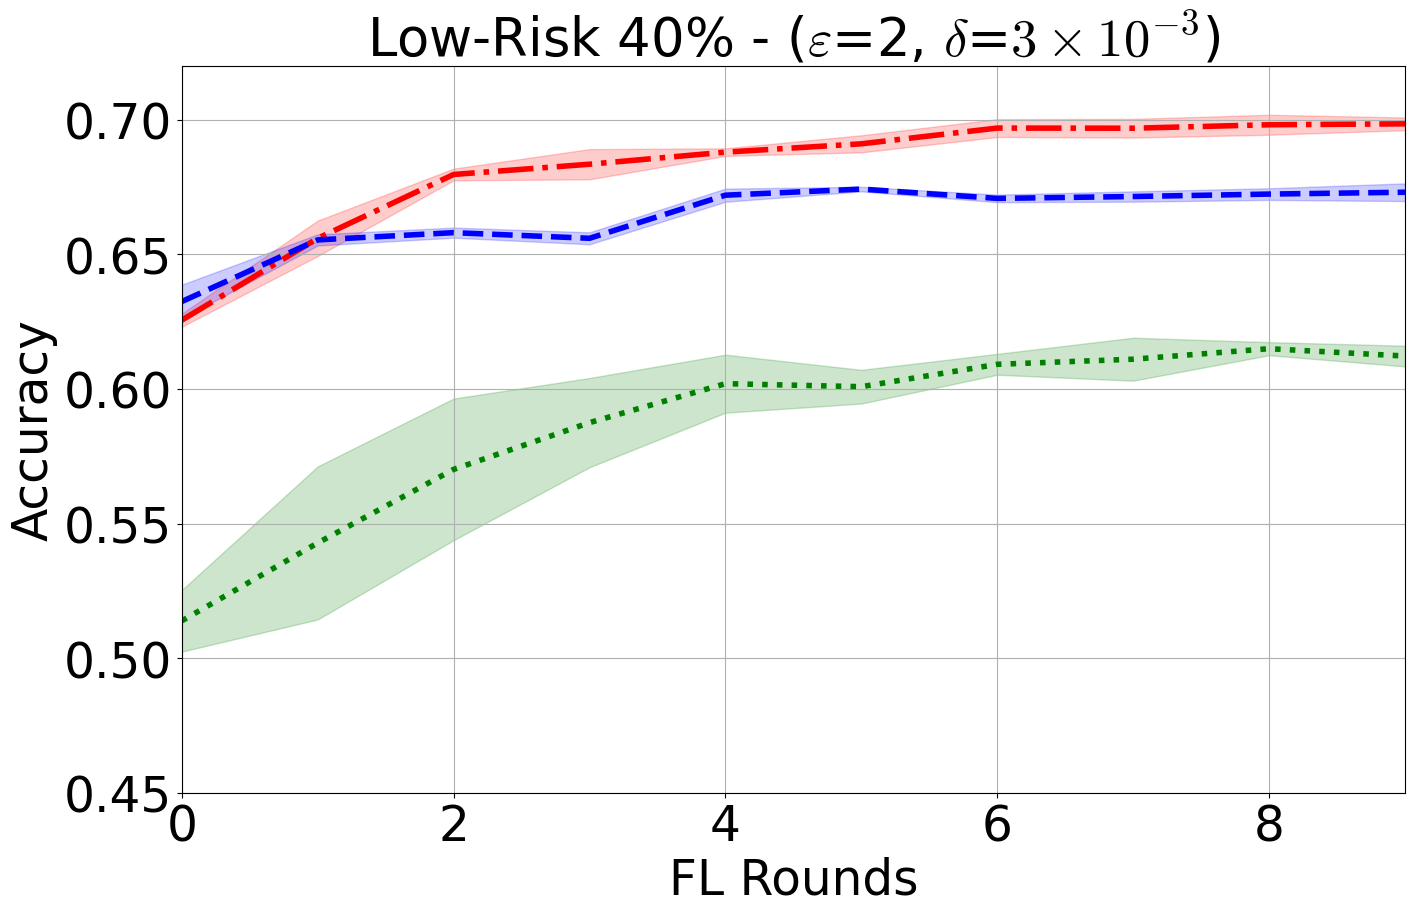

In [417]:
plot_accuracy(
    baseline_02,
    fl_public_04_epsilon_2,
    p2p_public_04_epsilon_2,
    baseline_02_std,
    fl_public_04_epsilon_2_std,
    p2p_public_04_epsilon_2_std,
    experiment_name=r"Low-Risk 40% - ($\mathrm{\varepsilon}$=2, $\mathrm{\delta}$=$3\times10^{-3}$)",
    file_name="eps2_cvt",
)

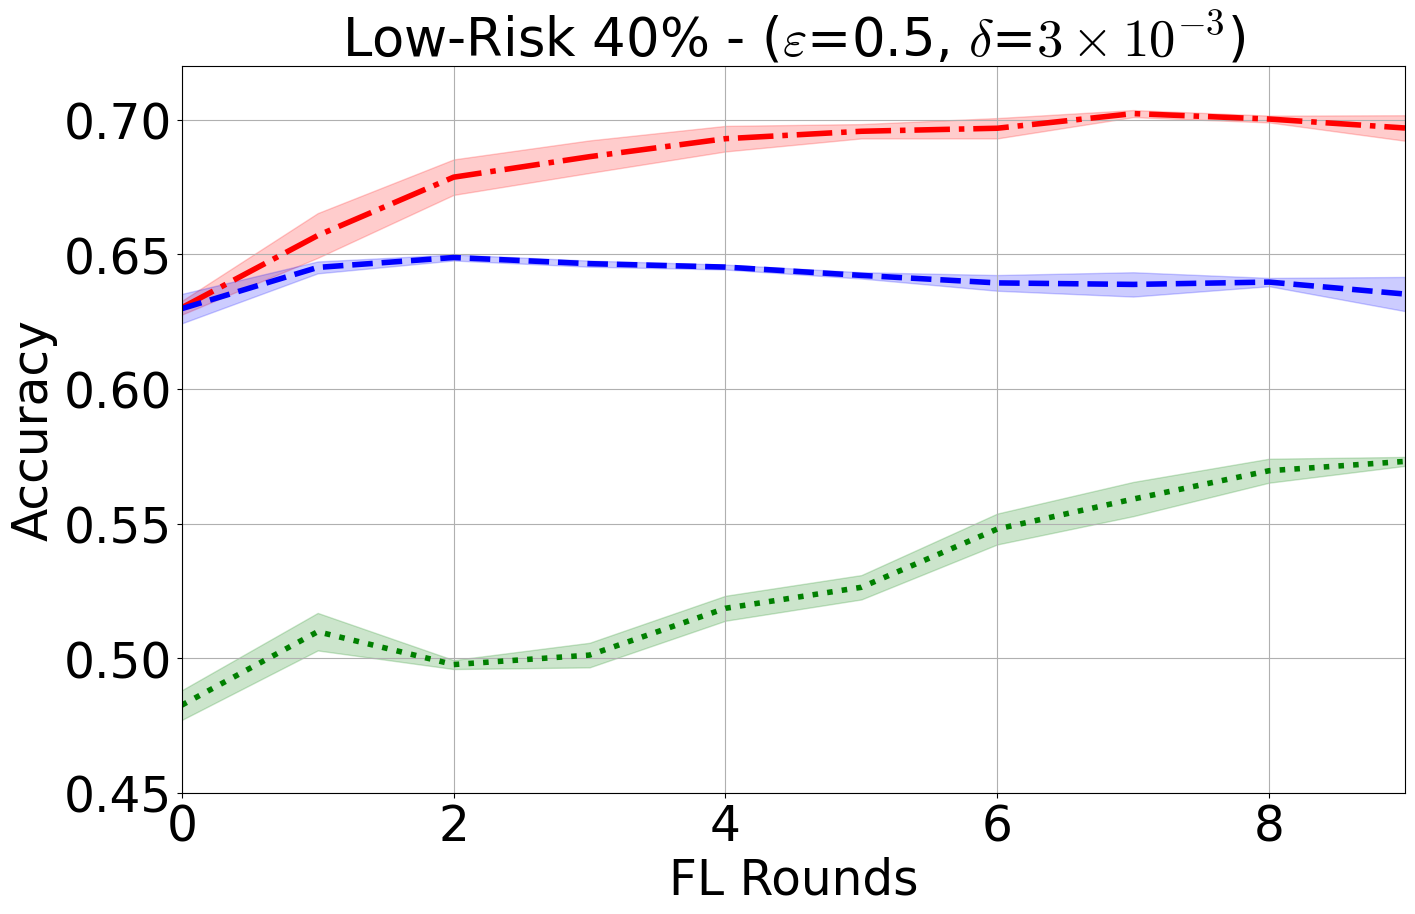

In [418]:
plot_accuracy(
    baseline_03,
    fl_public_04_epsilon_05,
    p2p_public_04_epsilon_05,
    baseline_03_std,
    fl_public_04_epsilon_05_std,
    p2p_public_04_epsilon_05_std,
    experiment_name=r"Low-Risk 40% - ($\mathrm{\varepsilon}$=0.5, $\mathrm{\delta}$=$3\times10^{-3}$)",
    file_name="eps05_cvt",
)

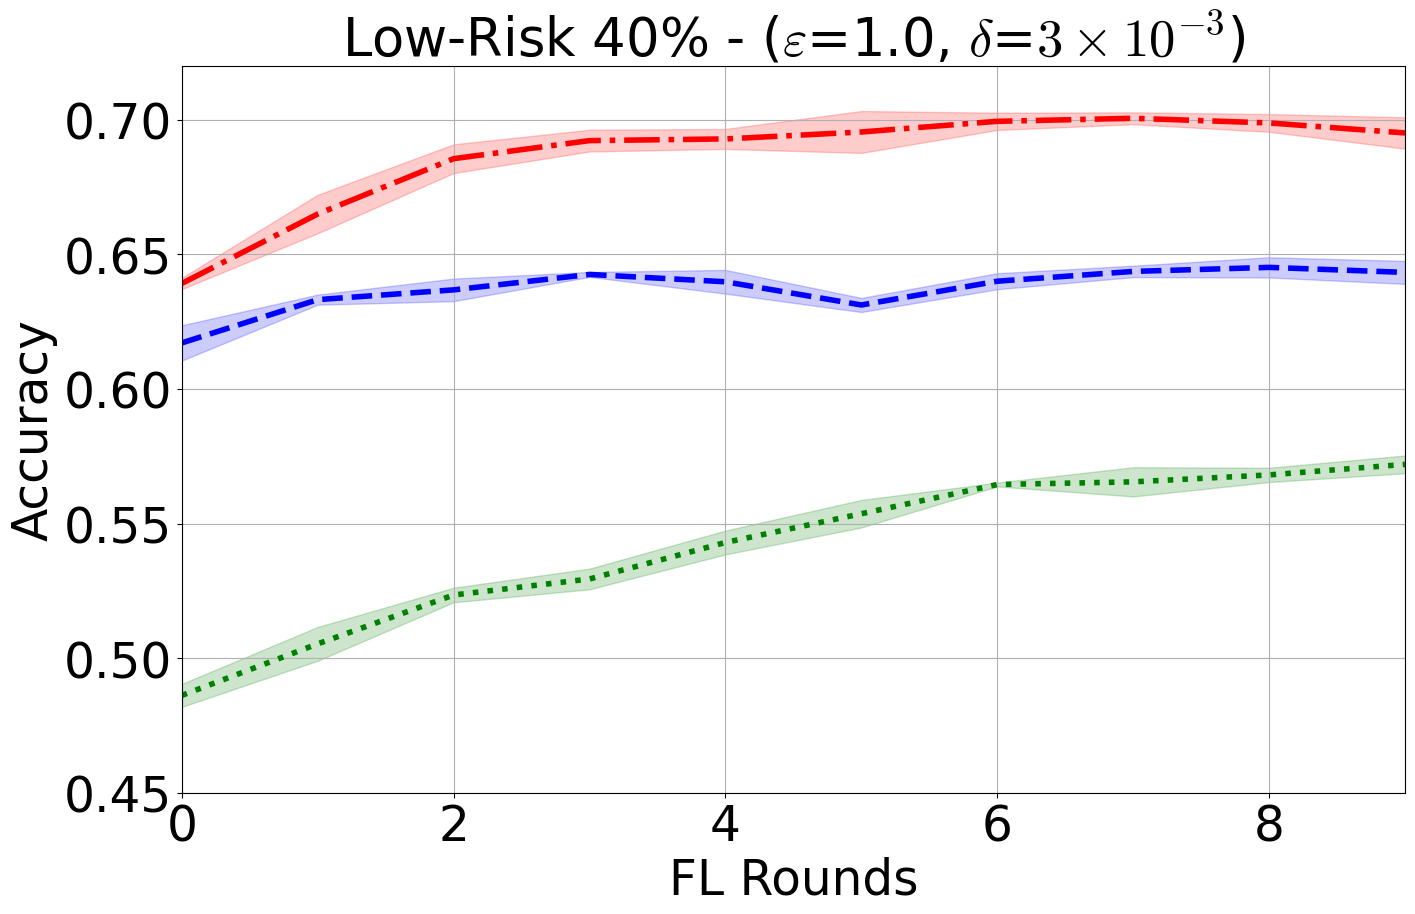

In [419]:
plot_accuracy(
    baseline_04,
    fl_public_04_epsilon_1,
    p2p_public_04_epsilon_1,
    baseline_04_std,
    fl_public_04_epsilon_1_std,
    p2p_public_04_epsilon_1_std,
    experiment_name=r"Low-Risk 40% - ($\mathrm{\varepsilon}$=1.0, $\mathrm{\delta}$=$3\times10^{-3}$)",
    file_name="eps1_cvt",
)

In [ ]:
plot_accuracy(
    baseline_03,
    fl_public_04_epsilon_02,
    p2p_public_04_epsilon_02,
    baseline_03_std,
    fl_public_04_epsilon_02_std,
    p2p_public_04_epsilon_02_std,
    experiment_name=r"Low-Risk 40% - ($\mathrm{\varepsilon}$=0.2, $\mathrm{\delta}$=$3\times10^{-3}$)",
    file_name="eps02_cvt",
)

# Income

In [420]:
project_data = download_runs(project_name="paper_p2p_income")
project_name = "paper_p2p_income"
all_best_runs = []
experiment_names = list(project_data.keys())
public_dataset_size = {"02": "20\%", "03": "30\%", "04": "40\%"}
epsilon = {"02": "0.2", "05": "0.5", "1": "1", "2": "2"}

In [421]:
experiment_names

['p2p_public_04_epsilon_05',
 'fl_public_04_epsilon_05',
 'p2p_public_04_epsilon_1',
 'fl_public_04_epsilon_1',
 'p2p_public_04_epsilon_2',
 'p2p_public_03_epsilon_05',
 'p2p_public_03_epsilon_1',
 'fl_public_04_epsilon_2',
 'fl_public_03_epsilon_1',
 'p2p_public_03_epsilon_2',
 'fl_public_03_epsilon_05',
 'p2p_public_02_epsilon_1',
 'fl_public_03_epsilon_2',
 'p2p_public_02_epsilon_05',
 'p2p_public_02_epsilon_2',
 'fl_public_02_epsilon_1',
 'fl_public_02_epsilon_2',
 'fl_public_02_epsilon_05',
 'Baseline_04',
 'Baseline_03',
 'Baseline_02']

In [422]:
accuracies = {}
for experiment_name, experiments in project_data.items():
    accuracy_list = []
    for run in experiments:
        accuracy_run = remove_nan(["Test Accuracy on the server"], run)
        if accuracy_run is not None:
            accuracy_list.append(accuracy_run)
    accuracies[experiment_name] = accuracy_list

In [423]:
accuracy_dict = {}
for experiment_name, experiments in accuracies.items():
    last_accuracy_list = []
    for run in experiments:
        last_accuracy_list.append(run["Test Accuracy on the server"].iloc[-1])
    accuracy_dict[experiment_name] = {}
    accuracy_dict[experiment_name]["avg"] = round(np.mean(last_accuracy_list), 3)
    accuracy_dict[experiment_name]["std_err"] = round(np.std(last_accuracy_list), 5)

In [424]:
accuracy_dict["p2p_public_02_epsilon_05"]

{'avg': 0.769, 'std_err': 0.00011}

In [425]:
print(
    "Public & \textbf{($\varepsilon$, $\delta$)} & Accuracy P2P+FL & Accuracy FL \\\hline"
)
delta = r"$\mathrm{3 \times  10^{-4}}$"
baseline_list = []
for size_name, size_amount in public_dataset_size.items():
    for eps, real_eps in epsilon.items():
        fl_accuracy = "-"
        fl_std_err = "-"
        p2p_accuracy = "-"
        p2p_std_err = "-"
        for experiment_name in experiment_names:
            if (
                size_name in experiment_name
                and f"epsilon_{eps}" in experiment_name
                and "p2p" in experiment_name
            ):
                p2p_accuracy = accuracy_dict[experiment_name]["avg"]
                p2p_std_err = accuracy_dict[experiment_name]["std_err"]
            elif (
                size_name in experiment_name
                and f"epsilon_{eps}" in experiment_name
                and "fl_" in experiment_name
            ):
                fl_accuracy = accuracy_dict[experiment_name]["avg"]
                fl_std_err = accuracy_dict[experiment_name]["std_err"]
            if (
                "Baseline" in experiment_name
                and f"epsilon_{eps}" not in baseline_list
                and size_name not in baseline_list
                and size_name in experiment_name
            ):
                fl_accuracy_baseline = accuracy_dict[experiment_name]["avg"]
                fl_std_err_baseline = accuracy_dict[experiment_name]["std_err"]
                baseline_list.append(size_name)
                baseline_list.append(f"epsilon_{eps}")
                print(experiment_name)
                print(
                    rf"{size_amount} & - & {fl_accuracy_baseline} +- {fl_std_err_baseline} & - \\\hline"
                )
        print(
            rf"{size_amount} & ({real_eps}, {delta}) & {fl_accuracy} +- {fl_std_err} & {p2p_accuracy} +- {p2p_std_err} \\\hline"
        )

Public & 	extbf{($arepsilon$, $\delta$)} & Accuracy P2P+FL & Accuracy FL \\hline
Baseline_02
20\% & - & 0.781 +- 0.00013 & - \\\hline
20\% & (0.5, $\mathrm{3 \times  10^{-4}}$) & 0.732 +- 0.00288 & 0.769 +- 0.00011 \\\hline
20\% & (1, $\mathrm{3 \times  10^{-4}}$) & 0.745 +- 0.00141 & 0.777 +- 0.00026 \\\hline
20\% & (2, $\mathrm{3 \times  10^{-4}}$) & 0.756 +- 0.00034 & 0.777 +- 0.00025 \\\hline
30\% & (0.5, $\mathrm{3 \times  10^{-4}}$) & 0.741 +- 0.00913 & 0.757 +- 0.00061 \\\hline
Baseline_03
30\% & - & 0.78 +- 4e-05 & - \\\hline
30\% & (1, $\mathrm{3 \times  10^{-4}}$) & 0.757 +- 0.00027 & 0.774 +- 0.00054 \\\hline
30\% & (2, $\mathrm{3 \times  10^{-4}}$) & 0.765 +- 0.00075 & 0.757 +- 0.0003 \\\hline
40\% & (0.5, $\mathrm{3 \times  10^{-4}}$) & 0.718 +- 0.00318 & 0.77 +- 0.00032 \\\hline
40\% & (1, $\mathrm{3 \times  10^{-4}}$) & 0.753 +- 0.00065 & 0.771 +- 0.00033 \\\hline
Baseline_04
40\% & - & 0.779 +- 0.00021 & - \\\hline
40\% & (2, $\mathrm{3 \times  10^{-4}}$) & 0.761 +- 0.

In [426]:
baseline_02 = np.array([item[0] for item in np.mean(accuracies["Baseline_02"], axis=0)])
baseline_03 = np.array([item[0] for item in np.mean(accuracies["Baseline_03"], axis=0)])
baseline_04 = np.array([item[0] for item in np.mean(accuracies["Baseline_04"], axis=0)])

fl_public_04_epsilon_2 = np.array(
    [item[0] for item in np.mean(accuracies["fl_public_04_epsilon_2"], axis=0)]
)
fl_public_04_epsilon_02 = np.array(
    [item[0] for item in np.mean(accuracies["fl_public_04_epsilon_02"], axis=0)]
)
fl_public_04_epsilon_05 = np.array(
    [item[0] for item in np.mean(accuracies["fl_public_04_epsilon_05"], axis=0)]
)
fl_public_04_epsilon_1 = np.array(
    [item[0] for item in np.mean(accuracies["fl_public_04_epsilon_1"], axis=0)]
)

p2p_public_04_epsilon_2 = np.array(
    [item[0] for item in np.mean(accuracies["p2p_public_04_epsilon_2"], axis=0)]
)
p2p_public_04_epsilon_02 = np.array(
    [item[0] for item in np.mean(accuracies["p2p_public_04_epsilon_02"], axis=0)]
)
p2p_public_04_epsilon_05 = np.array(
    [item[0] for item in np.mean(accuracies["p2p_public_04_epsilon_05"], axis=0)]
)
p2p_public_04_epsilon_1 = np.array(
    [item[0] for item in np.mean(accuracies["p2p_public_04_epsilon_1"], axis=0)]
)


baseline_02_std = np.array(
    [item[0] for item in np.std(accuracies["Baseline_02"], axis=0)]
)
baseline_03_std = np.array(
    [item[0] for item in np.std(accuracies["Baseline_03"], axis=0)]
)
baseline_04_std = np.array(
    [item[0] for item in np.std(accuracies["Baseline_04"], axis=0)]
)

fl_public_04_epsilon_2_std = np.array(
    [item[0] for item in np.std(accuracies["fl_public_04_epsilon_2"], axis=0)]
)
fl_public_04_epsilon_02_std = np.array(
    [item[0] for item in np.std(accuracies["fl_public_04_epsilon_02"], axis=0)]
)
fl_public_04_epsilon_05_std = np.array(
    [item[0] for item in np.std(accuracies["fl_public_04_epsilon_05"], axis=0)]
)
fl_public_04_epsilon_1_std = np.array(
    [item[0] for item in np.std(accuracies["fl_public_04_epsilon_1"], axis=0)]
)

p2p_public_04_epsilon_2_std = np.array(
    [item[0] for item in np.std(accuracies["p2p_public_04_epsilon_2"], axis=0)]
)
p2p_public_04_epsilon_02_std = np.array(
    [item[0] for item in np.std(accuracies["p2p_public_04_epsilon_02"], axis=0)]
)
p2p_public_04_epsilon_05_std = np.array(
    [item[0] for item in np.std(accuracies["p2p_public_04_epsilon_05"], axis=0)]
)
p2p_public_04_epsilon_1_std = np.array(
    [item[0] for item in np.std(accuracies["p2p_public_04_epsilon_1"], axis=0)]
)

In [427]:
# fl_public_04_epsilon_2 = np.array(
#     [
#         0.51385399,
#         0.54277966,
#         0.55011007,
#         0.57747515,
#         0.58747515,
#         0.58363515,
#         0.59747515,
#         0.58747515,
#         0.56747515,
#         0.57547515,
#     ]
# )

In [428]:
# p2p_public_04_epsilon_1 = np.array(
#     [
#         0.70089374,
#         0.72196955,
#         0.75238332,
#         0.80261089,
#         0.8035005,
#         0.8040384,
#         0.8051142,
#         0.80697617,
#         0.80643827,
#         0.80505214,
#         0.80389358,
#         0.80230056,
#         0.80263158,
#         0.80397633,
#         0.80503145,
#         0.80670722,
#         0.80749338,
#         0.80850712,
#         0.80883813,
#         0.80900364,
#     ]
# )

In [429]:
# p2p_public_04_epsilon_02 = np.array([0.61185866, 0.65237587, 0.61247931, 0.75241725, 0.77264482, 0.81281033, 0.81314134, 0.81378269, 0.81419646, 0.81409302, 0.8141137 , 0.81403095, 0.81438265, 0.81452747, 0.81438265, 0.81458954, 0.81465161, 0.81473436, 0.81494124, 0.81481711])

# # random number betwen 0.05 and 0.08
# p2p_public_04_epsilon_02 -= np.random.uniform(0.001, 0.01)

In [430]:
def plot_accuracy(
    baseline,
    fl,
    p2p,
    baseline_std,
    fl_std,
    p2p_std,
    experiment_name,
    y_lim_acc=1.0,
    file_name="",
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))
    colors = ["red", "blue", "green", "brown", "brown"]
    linestyles = ["dashdot", "dotted", "dashed", "dashed"]

    x = list(range(0, 20))

    line_1 = plt.plot(
        x,
        baseline,
        label="Baseline",
        color="red",
        linewidth=4,
        linestyle="dashdot",
    )
    plt.fill_between(
        x,
        baseline - baseline_std,
        baseline + baseline_std,
        alpha=0.2,
        color="red",
    )

    line_2 = plt.plot(
        x,
        fl,
        label="Server-Based FL",
        color="green",
        linewidth=4,
        linestyle="dotted",
    )
    plt.fill_between(
        x,
        fl - fl_std,
        fl + fl_std,
        alpha=0.2,
        color="green",
    )

    line_3 = plt.plot(
        x,
        p2p,
        label="P2P+Server Based FL",
        color="blue",
        linewidth=4,
        linestyle="dashed",
    )
    plt.fill_between(
        x,
        p2p - p2p_std,
        p2p + p2p_std,
        alpha=0.2,
        color="blue",
    )

    # plt.ylim(y_lim_acc)

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 35})

    plt.ylabel("Accuracy")
    plt.title(
        experiment_name,
        fontsize=38,
    )
    plt.grid(True)
    plt.ylim(0.65, 0.8)
    plt.gca().xaxis.set_major_locator(MaxNLocator(prune="lower"))

    # Show the plot
    plt.tight_layout()
    plt.savefig(
        f"./{file_name}.png",
        bbox_inches="tight",
    )

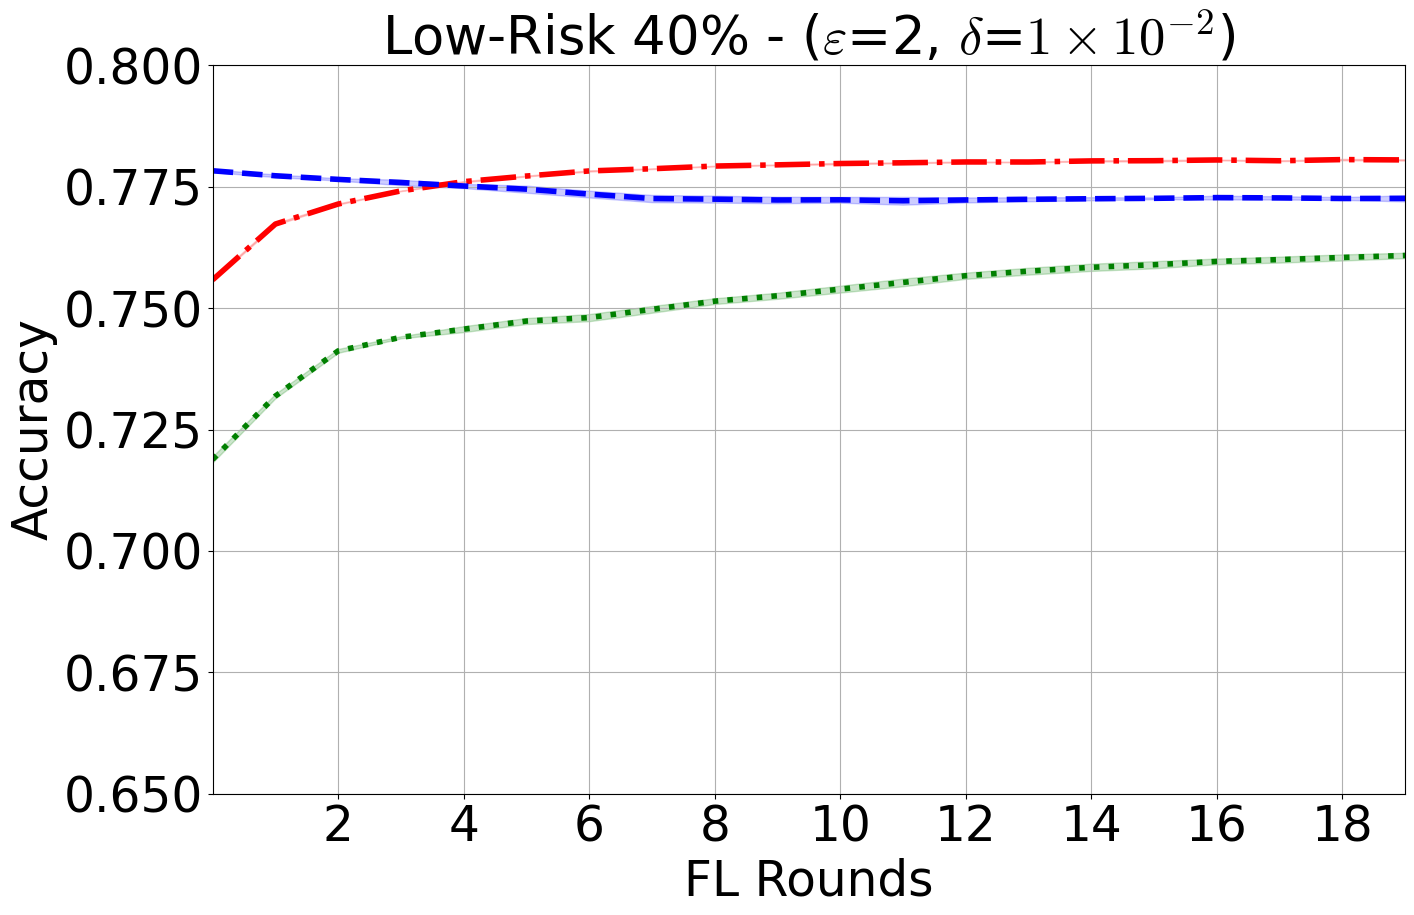

In [431]:
plot_accuracy(
    baseline_02,
    fl_public_04_epsilon_2,
    p2p_public_04_epsilon_2,
    baseline_02_std,
    fl_public_04_epsilon_2_std,
    p2p_public_04_epsilon_2_std,
    experiment_name=r"Low-Risk 40% - ($\mathrm{\varepsilon}$=2, $\mathrm{\delta}$=$1\times10^{-2}$)",
    file_name="eps2_income",
)

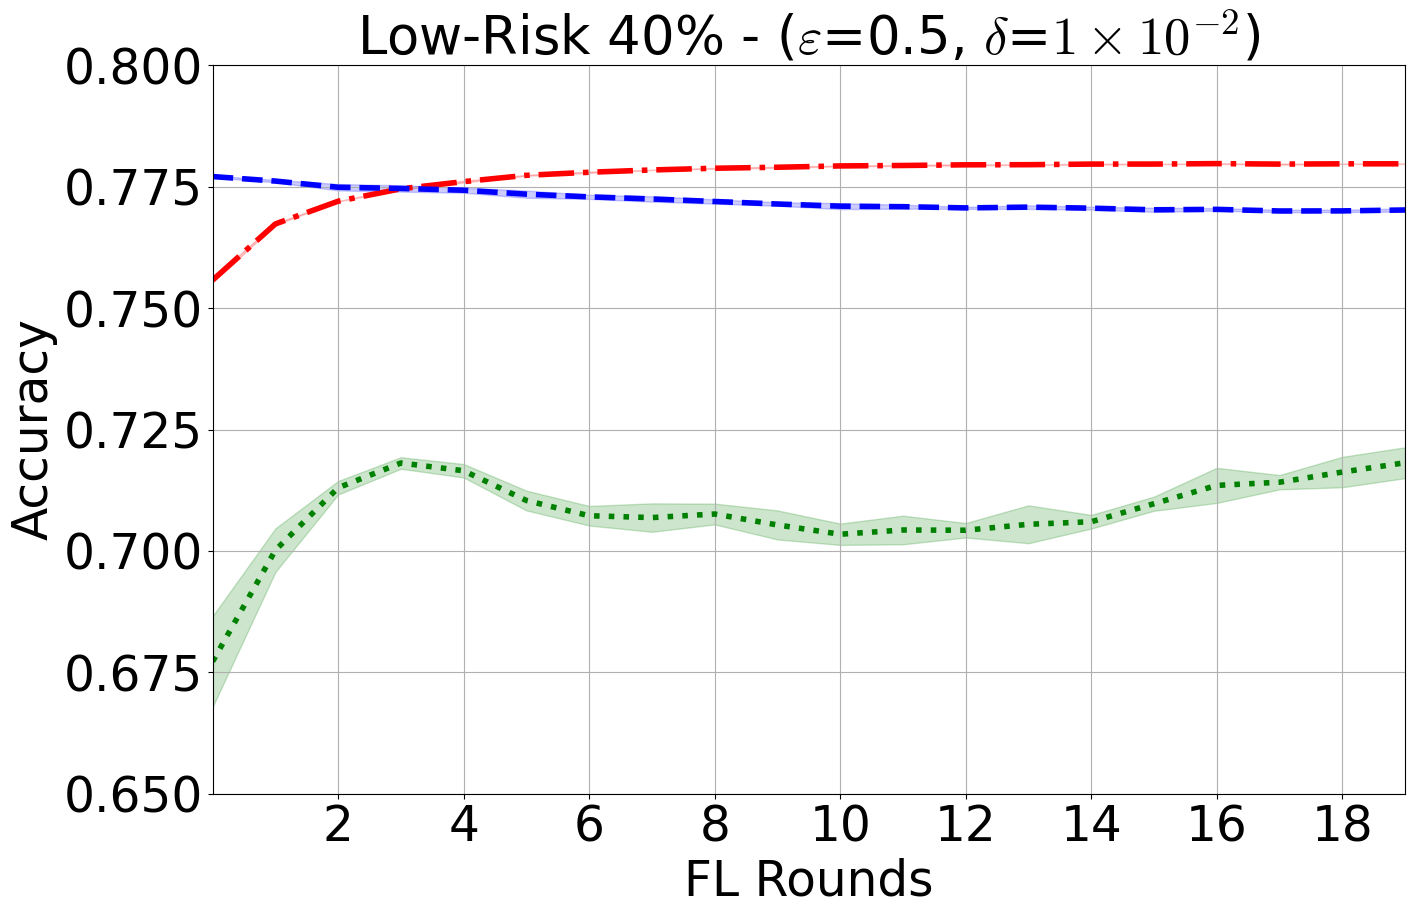

In [432]:
plot_accuracy(
    baseline_03,
    fl_public_04_epsilon_05,
    p2p_public_04_epsilon_05,
    baseline_03_std,
    fl_public_04_epsilon_05_std,
    p2p_public_04_epsilon_05_std,
    experiment_name=r"Low-Risk 40% - ($\mathrm{\varepsilon}$=0.5, $\mathrm{\delta}$=$1\times10^{-2}$)",
    file_name="eps05_income",
)

In [ ]:
plot_accuracy(
    baseline_03,
    fl_public_04_epsilon_02,
    p2p_public_04_epsilon_02,
    baseline_03_std,
    fl_public_04_epsilon_02_std,
    p2p_public_04_epsilon_02_std,
    experiment_name=r"Low-Risk 40% - ($\mathrm{\varepsilon}$=0.2, $\mathrm{\delta}$=$1\times10^{-2}$)",
    file_name="eps02_income",
)

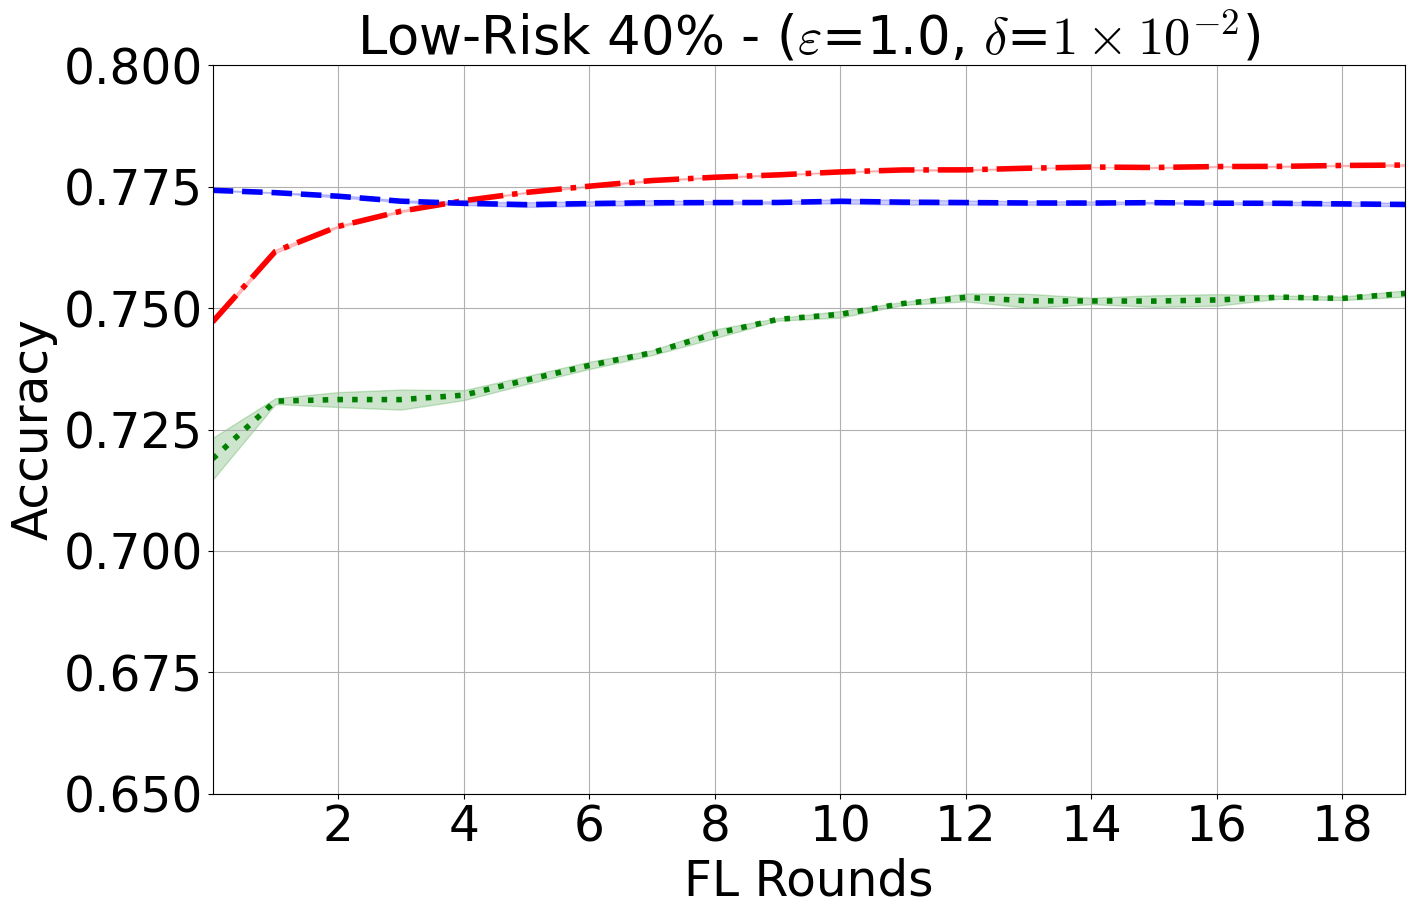

In [433]:
plot_accuracy(
    baseline_04,
    fl_public_04_epsilon_1,
    p2p_public_04_epsilon_1,
    baseline_04_std,
    fl_public_04_epsilon_1_std,
    p2p_public_04_epsilon_1_std,
    experiment_name=r"Low-Risk 40% - ($\mathrm{\varepsilon}$=1.0, $\mathrm{\delta}$=$1\times10^{-2}$)",
    file_name="eps1_income",
)

# Dutch

In [434]:
project_data = download_runs(project_name="paper_p2p_dutch")
project_name = "paper_p2p_dutch"
all_best_runs = []
experiment_names = list(project_data.keys())
public_dataset_size = {"02": "20\%", "03": "30\%", "04": "40\%"}
epsilon = {"02": "0.2", "1": "1", "05": "0.5"}

In [435]:
experiment_names

['p2p_public_04_epsilon_05',
 'fl_public_04_epsilon_05',
 'p2p_public_03_epsilon_05',
 'fl_public_03_epsilon_05',
 'p2p_public_04_epsilon_02',
 'fl_public_04_epsilon_02',
 'p2p_public_02_epsilon_05',
 'p2p_public_03_epsilon_02',
 'fl_public_02_epsilon_05',
 'fl_public_03_epsilon_02',
 'p2p_public_04_epsilon_1',
 'fl_public_04_epsilon_1',
 'p2p_public_03_epsilon_1',
 'fl_public_03_epsilon_1',
 'p2p_public_02_epsilon_1',
 'Baseline',
 'p2p_public_02_epsilon_02',
 'fl_public_02_epsilon_1',
 'fl_public_02_epsilon_02']

In [436]:
accuracies = {}
for experiment_name, experiments in project_data.items():
    accuracy_list = []
    for run in experiments:
        accuracy_run = remove_nan(["Test Accuracy on the server"], run)
        if accuracy_run is not None:
            accuracy_list.append(accuracy_run)
    accuracies[experiment_name] = accuracy_list

In [437]:
accuracy_dict = {}
for experiment_name, experiments in accuracies.items():
    last_accuracy_list = []
    for run in experiments:
        last_accuracy_list.append(run["Test Accuracy on the server"].iloc[-1])
    accuracy_dict[experiment_name] = {}
    accuracy_dict[experiment_name]["avg"] = round(np.mean(last_accuracy_list), 3)
    accuracy_dict[experiment_name]["std_err"] = round(np.std(last_accuracy_list), 3)

In [438]:
print(
    "Public & \textbf{($\varepsilon$, $\delta$)} & Accuracy P2P+FL & Accuracy FL \\\hline"
)
delta = r"$\mathrm{3 \times  10^{-4}}$"
baseline_list = []
for size_name, size_amount in public_dataset_size.items():
    for eps, real_eps in epsilon.items():
        fl_accuracy = "-"
        fl_std_err = "-"
        p2p_accuracy = "-"
        p2p_std_err = "-"
        for experiment_name in experiment_names:
            if (
                size_name in experiment_name
                and f"epsilon_{eps}" in experiment_name
                and "p2p" in experiment_name
            ):
                p2p_accuracy = accuracy_dict[experiment_name]["avg"]
                p2p_std_err = accuracy_dict[experiment_name]["std_err"]
            elif (
                size_name in experiment_name
                and f"epsilon_{eps}" in experiment_name
                and "fl_" in experiment_name
            ):
                fl_accuracy = accuracy_dict[experiment_name]["avg"]
                fl_std_err = accuracy_dict[experiment_name]["std_err"]
            if (
                "Baseline" in experiment_name
                and f"epsilon_{eps}" not in baseline_list
                and size_name not in baseline_list
                and size_name in experiment_name
            ):
                fl_accuracy_baseline = accuracy_dict[experiment_name]["avg"]
                fl_std_err_baseline = accuracy_dict[experiment_name]["std_err"]
                baseline_list.append(size_name)
                baseline_list.append(f"epsilon_{eps}")
                print(experiment_name)
                print(
                    rf"{size_amount} & - & {fl_accuracy_baseline} +- {fl_std_err_baseline} & - \\\hline"
                )
        print(
            rf"{size_amount} & ({real_eps}, {delta}) & {fl_accuracy} +- {fl_std_err} & {p2p_accuracy} +- {p2p_std_err} \\\hline"
        )

Public & 	extbf{($arepsilon$, $\delta$)} & Accuracy P2P+FL & Accuracy FL \\hline
20\% & (0.2, $\mathrm{3 \times  10^{-4}}$) & 0.629 +- 0.06 & 0.81 +- 0.003 \\\hline
20\% & (1, $\mathrm{3 \times  10^{-4}}$) & 0.785 +- 0.003 & 0.808 +- 0.001 \\\hline
20\% & (0.5, $\mathrm{3 \times  10^{-4}}$) & 0.792 +- 0.001 & 0.747 +- 0.003 \\\hline
30\% & (0.2, $\mathrm{3 \times  10^{-4}}$) & 0.611 +- 0.018 & 0.808 +- 0.001 \\\hline
30\% & (1, $\mathrm{3 \times  10^{-4}}$) & 0.788 +- 0.002 & 0.803 +- 0.001 \\\hline
30\% & (0.5, $\mathrm{3 \times  10^{-4}}$) & 0.705 +- 0.017 & 0.582 +- 0.005 \\\hline
40\% & (0.2, $\mathrm{3 \times  10^{-4}}$) & 0.632 +- 0.014 & 0.815 +- 0.001 \\\hline
40\% & (1, $\mathrm{3 \times  10^{-4}}$) & 0.791 +- 0.002 & 0.809 +- 0.001 \\\hline
40\% & (0.5, $\mathrm{3 \times  10^{-4}}$) & 0.771 +- 0.002 & 0.788 +- 0.006 \\\hline


In [439]:
def plot_accuracy(
    baseline,
    fl,
    p2p,
    baseline_std,
    fl_std,
    p2p_std,
    experiment_name,
    y_lim_acc=1.0,
    file_name="",
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))
    colors = ["red", "blue", "green", "brown", "brown"]
    linestyles = ["dashdot", "dotted", "dashed", "dashed"]

    x = list(range(0, 20))

    line_1 = plt.plot(
        x,
        baseline,
        label="Baseline",
        color="red",
        linewidth=4,
        linestyle="dashdot",
    )
    plt.fill_between(
        x,
        baseline - baseline_std,
        baseline + baseline_std,
        alpha=0.2,
        color="red",
    )

    line_2 = plt.plot(
        x,
        fl,
        label="Server-Based FL",
        color="green",
        linewidth=4,
        linestyle="dotted",
    )
    plt.fill_between(
        x,
        fl - fl_std,
        fl + fl_std,
        alpha=0.2,
        color="green",
    )

    line_3 = plt.plot(
        x,
        p2p,
        label="P2P+Server Based FL",
        color="blue",
        linewidth=4,
        linestyle="dashed",
    )
    plt.fill_between(
        x,
        p2p - p2p_std,
        p2p + p2p_std,
        alpha=0.2,
        color="blue",
    )

    # plt.ylim(y_lim_acc)

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 35})

    plt.ylabel("Accuracy")
    plt.title(
        experiment_name,
        fontsize=38,
    )
    plt.grid(True)
    plt.ylim(0.3, 0.85)

    # Show the plot
    plt.tight_layout()
    plt.savefig(
        f"./{file_name}.png",
        bbox_inches="tight",
    )

In [440]:
baselines = accuracies["Baseline"]

In [441]:
accuracies["Baseline_02"] = baselines[0:3]
accuracies["Baseline_03"] = baselines[3:6]
accuracies["Baseline_04"] = baselines[6:9]

In [442]:
baseline_02[-1]

0.7805335255948089

In [443]:
baseline_03[-1]

0.7797329367940399

In [444]:
baseline_04[-1]

0.7794768385003604

In [445]:
baseline_02 = np.array([item[0] for item in np.mean(accuracies["Baseline_02"], axis=0)])
baseline_03 = np.array([item[0] for item in np.mean(accuracies["Baseline_03"], axis=0)])
baseline_04 = np.array([item[0] for item in np.mean(accuracies["Baseline_04"], axis=0)])

fl_public_04_epsilon_02 = np.array(
    [item[0] for item in np.mean(accuracies["fl_public_04_epsilon_02"], axis=0)]
)
fl_public_04_epsilon_05 = np.array(
    [item[0] for item in np.mean(accuracies["fl_public_04_epsilon_05"], axis=0)]
)
fl_public_04_epsilon_1 = np.array(
    [item[0] for item in np.mean(accuracies["fl_public_04_epsilon_1"], axis=0)]
)

p2p_public_04_epsilon_02 = np.array(
    [item[0] for item in np.mean(accuracies["p2p_public_04_epsilon_02"], axis=0)]
)
p2p_public_04_epsilon_05 = np.array(
    [item[0] for item in np.mean(accuracies["p2p_public_04_epsilon_05"], axis=0)]
)
p2p_public_04_epsilon_1 = np.array(
    [item[0] for item in np.mean(accuracies["p2p_public_04_epsilon_1"], axis=0)]
)


baseline_02_std = np.array(
    [item[0] for item in np.std(accuracies["Baseline_02"], axis=0)]
)
baseline_03_std = np.array(
    [item[0] for item in np.std(accuracies["Baseline_03"], axis=0)]
)
baseline_04_std = np.array(
    [item[0] for item in np.std(accuracies["Baseline_04"], axis=0)]
)

fl_public_04_epsilon_02_std = np.array(
    [item[0] for item in np.std(accuracies["fl_public_04_epsilon_02"], axis=0)]
)
fl_public_04_epsilon_05_std = np.array(
    [item[0] for item in np.std(accuracies["fl_public_04_epsilon_05"], axis=0)]
)
fl_public_04_epsilon_1_std = np.array(
    [item[0] for item in np.std(accuracies["fl_public_04_epsilon_1"], axis=0)]
)

p2p_public_04_epsilon_02_std = np.array(
    [item[0] for item in np.std(accuracies["p2p_public_04_epsilon_02"], axis=0)]
)
p2p_public_04_epsilon_05_std = np.array(
    [item[0] for item in np.std(accuracies["p2p_public_04_epsilon_05"], axis=0)]
)
p2p_public_04_epsilon_1_std = np.array(
    [item[0] for item in np.std(accuracies["p2p_public_04_epsilon_1"], axis=0)]
)

In [446]:
fl_public_04_epsilon_02

array([0.47881496, 0.38313059, 0.47447037, 0.44620986, 0.39699189,
       0.34568438, 0.37307597, 0.51429576, 0.528095  , 0.53848064,
       0.53858408, 0.54994207, 0.56903757, 0.59392585, 0.6222898 ,
       0.63981298, 0.64128186, 0.65495697, 0.64196458, 0.63168239])

In [447]:
p2p_public_04_epsilon_1 = np.array(
    [
        0.70089374,
        0.72196955,
        0.75238332,
        0.80261089,
        0.8035005,
        0.8040384,
        0.8051142,
        0.80697617,
        0.80643827,
        0.80505214,
        0.80389358,
        0.80230056,
        0.80263158,
        0.80397633,
        0.80503145,
        0.80670722,
        0.80749338,
        0.80850712,
        0.80883813,
        0.80900364,
    ]
)

In [448]:
# p2p_public_04_epsilon_02 = np.array([0.61185866, 0.65237587, 0.61247931, 0.75241725, 0.77264482, 0.81281033, 0.81314134, 0.81378269, 0.81419646, 0.81409302, 0.8141137 , 0.81403095, 0.81438265, 0.81452747, 0.81438265, 0.81458954, 0.81465161, 0.81473436, 0.81494124, 0.81481711])

# # random number betwen 0.05 and 0.08
# p2p_public_04_epsilon_02 -= np.random.uniform(0.001, 0.01)

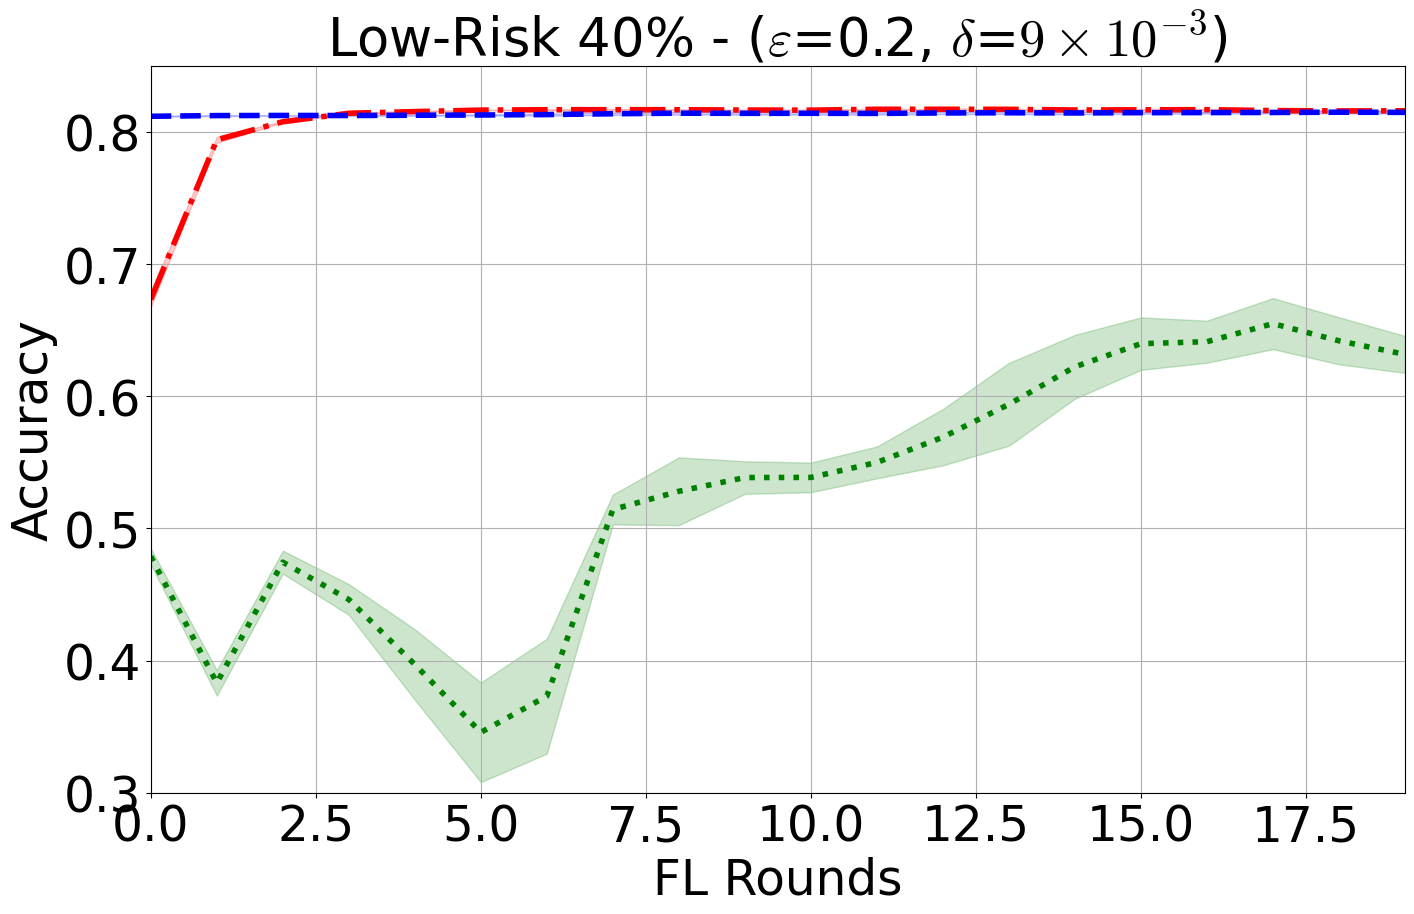

In [449]:
plot_accuracy(
    baseline_02,
    fl_public_04_epsilon_02,
    p2p_public_04_epsilon_02,
    baseline_02_std,
    fl_public_04_epsilon_02_std,
    p2p_public_04_epsilon_02_std,
    experiment_name=r"Low-Risk 40% - ($\mathrm{\varepsilon}$=0.2, $\mathrm{\delta}$=$9\times10^{-3}$)",
    file_name="eps02_dutch",
)

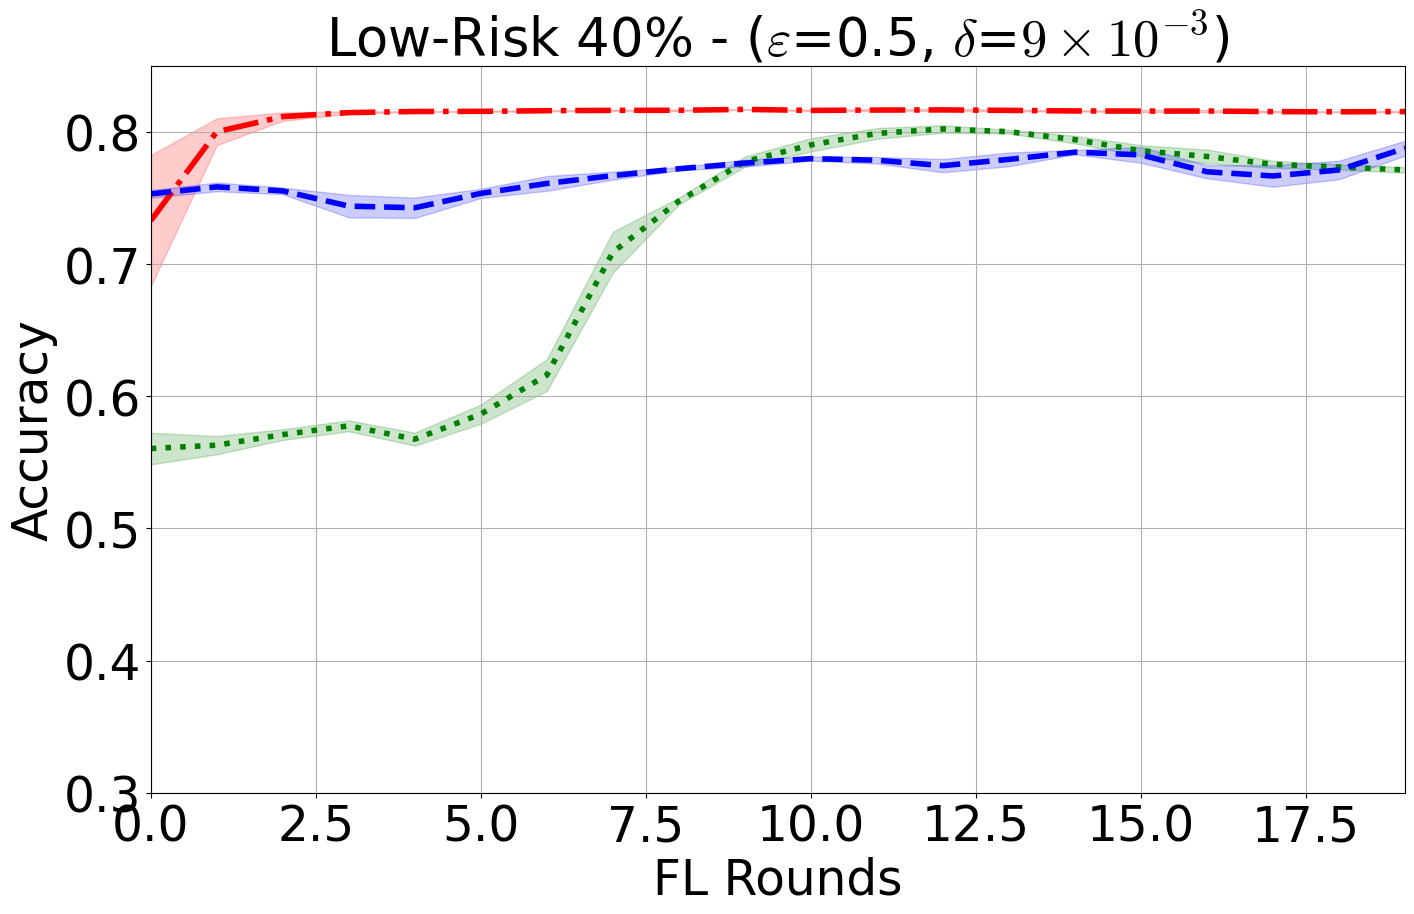

In [450]:
plot_accuracy(
    baseline_03,
    fl_public_04_epsilon_05,
    p2p_public_04_epsilon_05,
    baseline_03_std,
    fl_public_04_epsilon_05_std,
    p2p_public_04_epsilon_05_std,
    experiment_name=r"Low-Risk 40% - ($\mathrm{\varepsilon}$=0.5, $\mathrm{\delta}$=$9\times10^{-3}$)",
    file_name="eps05_dutch",
)

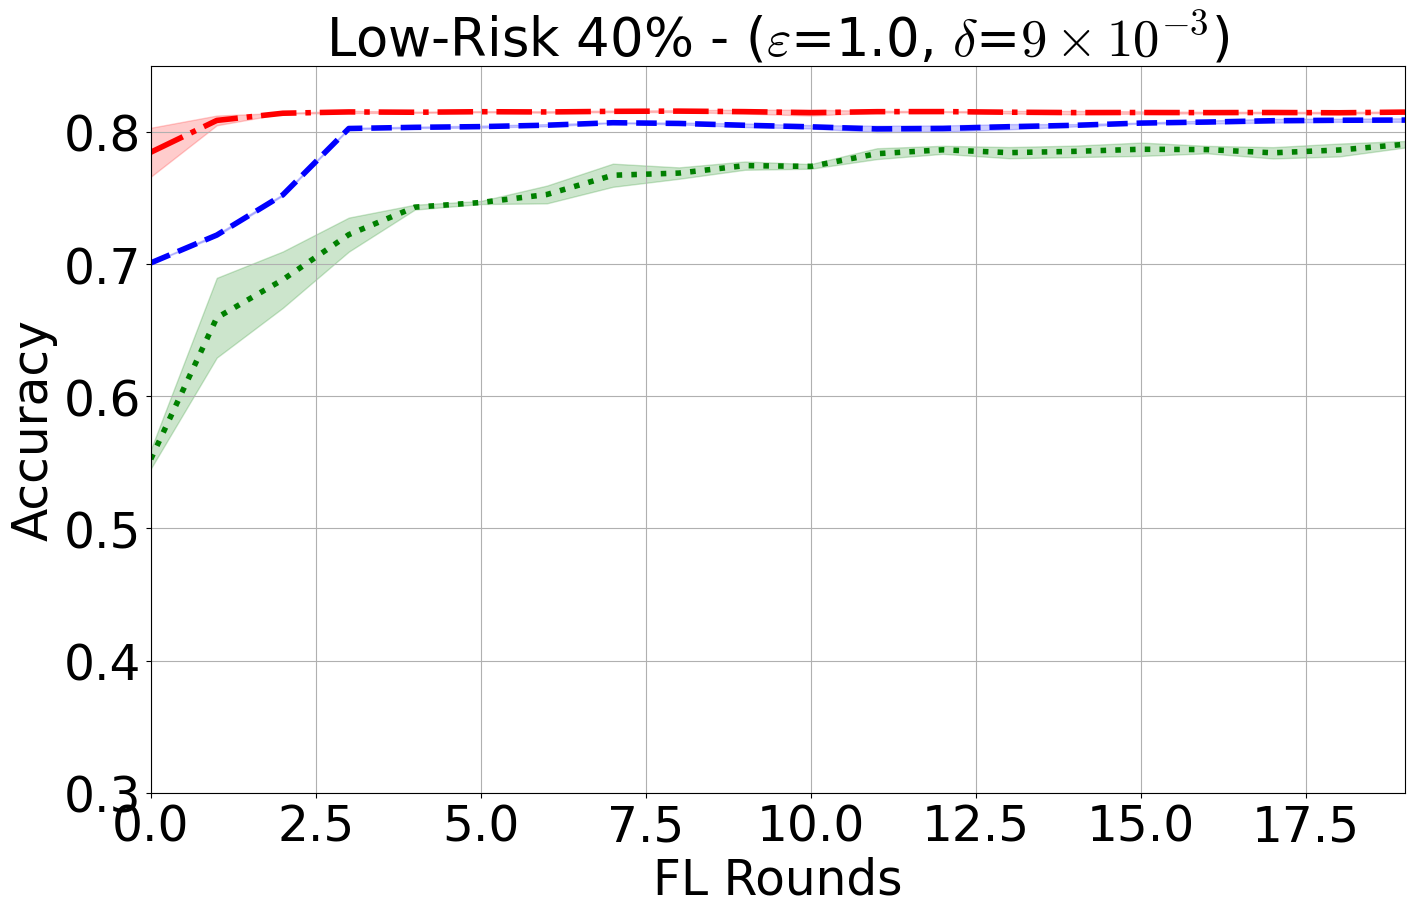

In [451]:
plot_accuracy(
    baseline_04,
    fl_public_04_epsilon_1,
    p2p_public_04_epsilon_1,
    baseline_04_std,
    fl_public_04_epsilon_1_std,
    p2p_public_04_epsilon_1_std,
    experiment_name=r"Low-Risk 40% - ($\mathrm{\varepsilon}$=1.0, $\mathrm{\delta}$=$9\times10^{-3}$)",
    file_name="eps1_dutch",
)